# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Tuple, Union, Sequence

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import PIL


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm
import json

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/urothel_ca')
PATH_WSIS = PATH/'Neue_Scans_Urothelkarzinome'
#PATH_ROIS = PATH/'Rois_Christoph'
PATH_ROIS = PATH/'Rois_Samir'
PATH_ROIS_ADJUSTED = PATH/'Rois_Samir_adjusted'
PATH_EXCEL_SHEET = PATH/'Data_Sheet_MIER_22112021.xlsx'


seed = 42
np.random.seed(seed)

# Data 

In [3]:
wsi_mrxs_paths = [p for p in PATH_WSIS.ls() if p.suffix == '.mrxs']
len(wsi_mrxs_paths)

239

In [4]:
wsi_dir_paths = [p for p in PATH_WSIS.ls() if p.suffix == '']
len(wsi_dir_paths)

239

In [5]:
json_paths = PATH_ROIS.ls()
len(json_paths)

233

## get rois for each wsi path

### wsi path to json file mapping

In [6]:
def find_json_path(mrxs_path:pathlib.Path)->pathlib.Path:
    stem = mrxs_path.stem
    for jp in json_paths:
        if(jp.stem == stem):
            return jp
    return None

In [7]:
wsi_mrxs_to_json_path = {}
wsi_mrxs_paths_without_corresponding_json_file = []
for mrxs_p in wsi_mrxs_paths:
    jp = find_json_path(mrxs_path=mrxs_p)
    if(jp is not None):
        wsi_mrxs_to_json_path[mrxs_p] = jp
    else:
        wsi_mrxs_paths_without_corresponding_json_file.append(mrxs_p)

In [8]:
len(wsi_mrxs_to_json_path)

233

In [9]:
len(wsi_mrxs_paths_without_corresponding_json_file)

6

### custom function that creates PolygonHelper objects from a given json file with the roi coordinates

In [10]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]]):
        self.level = level
        self.vertices = vertices

def get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            #skip rois that are not classified as Tumor
            if(annotation["properties"]["classification"]["name"] == "Tumor"):
                if(annotation["geometry"]["type"] == 'MultiPolygon'):
                    multi_polygon_vertices = annotation["geometry"]["coordinates"]
                    #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                    ##QuPath produces Polygons and Multipolygons 
                    ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                    ##multipolygon-for-shapefiles-in-qgis/225373)
                    ##This loop separates Multipolygons into individual Polygons
                    for sub_polygon_vertices in multi_polygon_vertices:
                        sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                        if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                            #print(f'/1/: {sub_polygon_vertices_array.shape}')
                            polygons.append(__PolygonHelper(level=0, vertices=sub_polygon_vertices_array))
                        else:
                            for elem in sub_polygon_vertices_array:
                                elem_array = np.array(elem).squeeze()
                                #print(f'/2/: {elem_array.shape}')
                                polygons.append(__PolygonHelper(level=0, vertices=elem_array))
                    
                elif(annotation["geometry"]["type"] == 'Polygon'):
                    vertices = annotation["geometry"]["coordinates"]
                    #print(f'/3/ len of vertices: {len(vertices)}')
                    for ls in vertices:               
                        #print(f'/4/: {np.array(ls).squeeze().shape}')
                        polygons.append(__PolygonHelper(level=0, vertices=np.array(ls, dtype=object).squeeze()))
                else:
                    assert False
    return polygons

### adjust misalligned rois because of black and white padding when mrxs files are opened by openslide

In [11]:
def is_row_black(img:Union[PIL.Image.Image, numpy.ndarray], row_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[row_num, :, :] == [0,0,0])

def is_column_black(img:Union[PIL.Image.Image, numpy.ndarray], column_num:int)->bool:
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    return np.all(img[:, column_num, :] == [0,0,0])

def get_num_of_black_rows_at_top(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_rows = 0
    while(is_row_black(img=img, row_num=n_rows)):
        n_rows += 1
    return n_rows

def get_num_of_black_columns_at_left(img:Union[PIL.Image.Image, numpy.ndarray])->int:
    n_columns = 0
    while(is_column_black(img=img, column_num=n_columns)):
        n_columns += 1
    return n_columns

class Row_or_col(Enum):
    ROW = 1
    COLUMN = 2
    
def is_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], index:int, row_or_col:Row_or_col)->bool:
    """
    checks if the by index specified row or column in the image contains only [0,0,0] == black
    or [255,255,255] == white RGB values
    """
    if(type(img) is PIL.Image.Image):
        img = util.pil_to_np_rgb(img)
    a = None
    if(row_or_col is Row_or_col.ROW):
        a = img[index, :, :]
    elif(row_or_col is Row_or_col.COLUMN):
        a = img[:, index, :]
    else:
        raise ValueError('row_or_col has insufficient value')
    return np.where(np.logical_and(np.ravel(a) > 0, np.ravel(a) < 255))[0].size == 0

def get_num_of_only_black_white(img:Union[PIL.Image.Image, numpy.ndarray], row_or_col:Row_or_col)->int:
    n = 0
    while(is_only_black_white(img=img, index=n, row_or_col=row_or_col)):
        n += 1
    return n

def adjust_rois(wsi_img:Union[PIL.Image.Image, numpy.ndarray], 
                wsi_img_level:int, 
                rois:List[roi.RegionOfInterestPolygon]):
    """
    returns new RegionOfInterestPolygon objects
    """
    cols_left = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.COLUMN)
    rows_top = get_num_of_only_black_white(img=wsi_img, row_or_col=Row_or_col.ROW)
    rois_adjusted = []
    for r in rois:
        new_vertices = util.polygon_to_numpy(r.polygon)
        new_vertices += [util.adjust_level(value_to_adjust=cols_left, from_level=wsi_img_level, to_level=r.level), 
                         util.adjust_level(value_to_adjust=rows_top, from_level=wsi_img_level, to_level=r.level)]
        r_new = roi.RegionOfInterestPolygon(roi_id=r.roi_id, vertices=new_vertices, level=r.level)
        rois_adjusted.append(r_new)

    return rois_adjusted

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def adjust_and_save_rois(wsi_path, json_path):
    print(f'wsi: {wsi_path.name}')
    print(f'json: {json_path.name}')
        
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    if(not save_path.exists()):    
        wh = tiles.WsiHandler(wsi_path=wsi_path)
        rois = roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                        polygons_from_json_func=get_polygons_from_json)       
        rois_adjusted = adjust_rois(wsi_img=wh.get_wsi_as_pil_image(level=5), wsi_img_level=5, rois=rois)               
        save_as_pickle(rois_adjusted, save_path)
    else:
        print(f'Already exists: {save_path}')    

In [12]:
failed = []
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    try:
        roi.adjust_and_save_rois(wsi_path, json_path)
    except:
        failed.append(wsi_path)

100%|██████████| 233/233 [00:00<00:00, 690164.43it/s]


In [13]:
#no stroma rois
wsi_path_to_rois = {}
for wsi_path, json_path in tqdm(list(wsi_mrxs_to_json_path.items())[:]):
    save_name = f'{wsi_path.stem}-rois_adjusted.pickle'
    save_path = PATH_ROIS_ADJUSTED/save_name
    rois = load_pickle(save_path)
    wsi_path_to_rois[wsi_path] = rois

100%|██████████| 233/233 [00:21<00:00, 10.67it/s]


## id and label funcs

In [14]:
data_sheet = pd.read_excel(PATH_EXCEL_SHEET, engine='openpyxl')

# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    split = wsi_path.stem.split('_')
    return f'{split[0]}_{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    tma_nr = wsi_path.stem.split('_')[1]
    row = data_sheet.iloc[int(tma_nr)-1]
    survival_time = row['Survival Time (months)']
    recurrence_free_survival = row['Recurrence Free Survival (months)']
    return [survival_time, recurrence_free_survival]

## tiles

In [15]:
tilesummaries_save_path = Path(f'./tilesummaries/001/')
tilesummaries = []

tilesummaries_saved_names = [p.stem for p in tilesummaries_save_path.ls()]

for wsi_path in tqdm(list(wsi_path_to_rois.keys())):
#for wsi_path in tqdm(list(failed_wsi_paths.keys())[:]):
    if(f'{wsi_path.stem}_tilesummary' in tilesummaries_saved_names):
        print(f'{wsi_path.stem} is loaded ...')
        tilesummaries.append(load_pickle(tilesummaries_save_path/f'{wsi_path.stem}_tilesummary.pickle'))
        pass
    else:
        print(f'{wsi_path.stem} tiles are calculated ...')    
        t = tiles.WsisToTilesParallel(wsi_paths=[wsi_path],
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_1,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.95, 
                                          verbose=True, 
                                          grids_per_roi=1, 
                                          optimize_grid_angles=False)[0]
        tilesummaries.append(t)
        p = tilesummaries_save_path/f'{t.wsi_path.stem}_tilesummary.pickle'
        save_as_pickle(t, p)

  0%|          | 0/233 [00:00<?, ?it/s]

MIER_140_M17 is loaded ...
MIER_151_M3 is loaded ...


  1%|▏         | 3/233 [00:00<00:29,  7.70it/s]

MIER_158_TUR2 is loaded ...
MIER_175_M12 is loaded ...


  3%|▎         | 7/233 [00:00<00:21, 10.54it/s]

MIER_200_M9 is loaded ...
MIER_211_C is loaded ...
MIER_217_C is loaded ...
MIER_236_C is loaded ...
MIER_40_D is loaded ...


  4%|▍         | 9/233 [00:00<00:24,  9.27it/s]

MIER_52_B is loaded ...


  5%|▌         | 12/233 [00:01<00:28,  7.63it/s]

MIER_74_M10 is loaded ...
MIER_184_I is loaded ...
MIER_46_A is loaded ...


  6%|▌         | 14/233 [00:01<00:32,  6.74it/s]

MIER_134_TUR1 is loaded ...
MIER_130_C is loaded ...


  7%|▋         | 16/233 [00:02<00:40,  5.36it/s]

MIER_233_TUR1 is loaded ...
MIER_127_G is loaded ...


  9%|▊         | 20/233 [00:02<00:25,  8.30it/s]

MIER_41_A is loaded ...
MIER_115_C is loaded ...
MIER_147_A is loaded ...
MIER_17_C is loaded ...


  9%|▉         | 22/233 [00:02<00:23,  8.80it/s]

MIER_183_A is loaded ...
MIER_222_M13 is loaded ...
MIER_50_A is loaded ...


 11%|█         | 25/233 [00:03<00:27,  7.58it/s]

MIER_79_D is loaded ...
MIER_167_L is loaded ...
MIER_187_M13 is loaded ...


 12%|█▏        | 29/233 [00:03<00:22,  9.01it/s]

MIER_145_B is loaded ...
MIER_71_H is loaded ...
MIER_6_C is loaded ...


 13%|█▎        | 31/233 [00:03<00:30,  6.67it/s]

MIER_229_TUR2 is loaded ...
MIER_154_M21 is loaded ...


 14%|█▍        | 33/233 [00:04<00:30,  6.55it/s]

MIER_8_B is loaded ...
MIER_36_A is loaded ...
MIER_22_E is loaded ...


 15%|█▌        | 36/233 [00:04<00:28,  6.92it/s]

MIER_221_C is loaded ...
MIER_70_B is loaded ...
MIER_35_F is loaded ...


 18%|█▊        | 41/233 [00:05<00:20,  9.31it/s]

MIER_142_M13 is loaded ...
MIER_29_C is loaded ...
MIER_164_C is loaded ...
MIER_225_G is loaded ...


 18%|█▊        | 43/233 [00:05<00:18, 10.32it/s]

MIER_131_B is loaded ...
MIER_91_C is loaded ...
MIER_13_C is loaded ...


 20%|██        | 47/233 [00:05<00:26,  7.08it/s]

MIER_14_A is loaded ...
MIER_201_B is loaded ...
MIER_110_TUR3 is loaded ...


 21%|██▏       | 50/233 [00:06<00:22,  8.26it/s]

MIER_117_E is loaded ...
MIER_202_G is loaded ...


 22%|██▏       | 52/233 [00:06<00:19,  9.47it/s]

MIER_182_TUR4 is loaded ...
MIER_161_B is loaded ...
MIER_107_M22 is loaded ...


 23%|██▎       | 54/233 [00:06<00:20,  8.91it/s]

MIER_51_C is loaded ...
MIER_82_TUR1 is loaded ...


 24%|██▍       | 56/233 [00:06<00:19,  9.25it/s]

MIER_95_B is loaded ...
MIER_237_M4 is loaded ...
MIER_23_G is loaded ...


 26%|██▌       | 60/233 [00:07<00:20,  8.48it/s]

MIER_199_M10 is loaded ...
MIER_15_B is loaded ...
MIER_16_B is loaded ...


 27%|██▋       | 62/233 [00:07<00:22,  7.57it/s]

MIER_26_B is loaded ...
MIER_75_B is loaded ...
MIER_85_M12 is loaded ...


 29%|██▉       | 67/233 [00:07<00:16, 10.35it/s]

MIER_156_M15 is loaded ...
MIER_189_TUR is loaded ...
MIER_170_TUR1 is loaded ...
MIER_196_D is loaded ...


 30%|██▉       | 69/233 [00:08<00:16,  9.80it/s]

MIER_190_D is loaded ...
MIER_144_TUR is loaded ...
MIER_206_M11 is loaded ...


 30%|███       | 71/233 [00:08<00:14, 10.81it/s]

MIER_128_C is loaded ...
MIER_195_A is loaded ...


 32%|███▏      | 75/233 [00:08<00:15, 10.38it/s]

MIER_223_TUR is loaded ...
MIER_11_A is loaded ...
MIER_125_B is loaded ...
MIER_109_A is loaded ...


 33%|███▎      | 78/233 [00:09<00:25,  6.03it/s]

MIER_112_TUR1 is loaded ...
MIER_108_J is loaded ...


 35%|███▍      | 81/233 [00:09<00:21,  7.08it/s]

MIER_169_TUR is loaded ...
MIER_101_TUR3 is loaded ...
MIER_235_C is loaded ...


 36%|███▌      | 83/233 [00:09<00:17,  8.60it/s]

MIER_241_M5 is loaded ...
MIER_39_D is loaded ...
MIER_100_B is loaded ...
MIER_136_A is loaded ...


 38%|███▊      | 88/233 [00:10<00:13, 10.87it/s]

MIER_218_A is loaded ...
MIER_244_A is loaded ...
MIER_193_TUR2 is loaded ...


 39%|███▊      | 90/233 [00:10<00:15,  9.21it/s]

MIER_162_TUR2 is loaded ...
MIER_7_E is loaded ...


 39%|███▉      | 92/233 [00:10<00:14,  9.61it/s]

MIER_4_A is loaded ...
MIER_73_B is loaded ...


 40%|████      | 94/233 [00:11<00:14,  9.34it/s]

MIER_28_E is loaded ...
MIER_3_D is loaded ...
MIER_168_M3 is loaded ...


 42%|████▏     | 98/233 [00:11<00:15,  8.56it/s]

MIER_133_B is loaded ...
MIER_163_M4 is loaded ...
MIER_62_A is loaded ...


 43%|████▎     | 100/233 [00:11<00:13,  9.61it/s]

MIER_242_TUR2 is loaded ...
MIER_63_M17 is loaded ...


 44%|████▍     | 102/233 [00:11<00:13,  9.44it/s]

MIER_57_M21 is loaded ...
MIER_58_C is loaded ...


 45%|████▍     | 104/233 [00:12<00:21,  6.12it/s]

MIER_231_M11 is loaded ...
MIER_150_M16 is loaded ...
MIER_213_C is loaded ...


 46%|████▌     | 107/233 [00:12<00:17,  7.21it/s]

MIER_116_A is loaded ...
MIER_234_TUR8 is loaded ...


 47%|████▋     | 109/233 [00:13<00:15,  8.21it/s]

MIER_137_D is loaded ...
MIER_111_TUR5 is loaded ...


 48%|████▊     | 111/233 [00:13<00:15,  8.12it/s]

MIER_56_M16 is loaded ...
MIER_68_TUR2 is loaded ...


 49%|████▉     | 114/233 [00:13<00:14,  8.05it/s]

MIER_103_B is loaded ...
MIER_105_F is loaded ...
MIER_113_M16 is loaded ...
MIER_185_TUR1 is loaded ...
MIER_186_M10 is loaded ...


 50%|█████     | 117/233 [00:13<00:13,  8.62it/s]

MIER_2_B is loaded ...
MIER_207_E is loaded ...


 51%|█████     | 119/233 [00:14<00:13,  8.62it/s]

MIER_226_A is loaded ...
MIER_228_A is loaded ...


 52%|█████▏    | 121/233 [00:14<00:12,  8.90it/s]

MIER_239_M1 is loaded ...
MIER_59_B is loaded ...


 53%|█████▎    | 123/233 [00:14<00:14,  7.72it/s]

MIER_83_M13 is loaded ...
MIER_92_TUR2 is loaded ...


 54%|█████▎    | 125/233 [00:14<00:13,  8.02it/s]

MIER_55_M11 is loaded ...
MIER_66_TUR1 is loaded ...


 55%|█████▍    | 127/233 [00:15<00:13,  8.13it/s]

MIER_138_TUR is loaded ...
MIER_34_B is loaded ...


 55%|█████▌    | 129/233 [00:15<00:12,  8.37it/s]

MIER_37_A is loaded ...


 57%|█████▋    | 132/233 [00:16<00:21,  4.75it/s]

MIER_42_C is loaded ...
MIER_87_M15 is loaded ...
MIER_165_B is loaded ...


 58%|█████▊    | 134/233 [00:16<00:17,  5.80it/s]

MIER_20_A is loaded ...
MIER_238_TUR2 is loaded ...


 58%|█████▊    | 136/233 [00:16<00:14,  6.63it/s]

MIER_209_M16 is loaded ...
MIER_114_M21 is loaded ...
MIER_33_C is loaded ...


 60%|██████    | 140/233 [00:16<00:10,  8.95it/s]

MIER_198_A is loaded ...
MIER_179_M13 is loaded ...
MIER_97_TUR1 is loaded ...


 61%|██████    | 142/233 [00:17<00:09,  9.47it/s]

MIER_157_M2 is loaded ...
MIER_141_F is loaded ...


 62%|██████▏   | 144/233 [00:17<00:09,  9.26it/s]

MIER_177_TUR2 is loaded ...
MIER_18_A is loaded ...


 63%|██████▎   | 147/233 [00:17<00:10,  8.08it/s]

MIER_227_E is loaded ...
MIER_159_TUR4 is loaded ...
MIER_152_TUR2 is loaded ...
MIER_27_A is loaded ...


 64%|██████▍   | 150/233 [00:18<00:09,  9.06it/s]

MIER_30_A is loaded ...
MIER_230_M12 is loaded ...


 65%|██████▌   | 152/233 [00:18<00:09,  8.97it/s]

MIER_60_G is loaded ...
MIER_9_B is loaded ...


 67%|██████▋   | 155/233 [00:18<00:10,  7.11it/s]

MIER_99_TUR1 is loaded ...
MIER_129_C is loaded ...
MIER_172_F is loaded ...


 68%|██████▊   | 159/233 [00:19<00:08,  9.13it/s]

MIER_173_B is loaded ...
MIER_176_TUR is loaded ...
MIER_180_F is loaded ...
MIER_215_M18 is loaded ...


 69%|██████▉   | 161/233 [00:19<00:07, 10.06it/s]

MIER_219_A is loaded ...
MIER_246_C is loaded ...
MIER_38_G is loaded ...


 70%|██████▉   | 163/233 [00:19<00:07,  9.43it/s]

MIER_61_A is loaded ...
MIER_240_M16 is loaded ...


 71%|███████   | 165/233 [00:19<00:07,  9.52it/s]

MIER_126_E is loaded ...
MIER_174_D is loaded ...


 72%|███████▏  | 167/233 [00:19<00:06,  9.60it/s]

MIER_203_M13 is loaded ...
MIER_10_A is loaded ...


 73%|███████▎  | 171/233 [00:21<00:12,  5.02it/s]

MIER_232_M10 is loaded ...
MIER_72_A is loaded ...
MIER_76_B is loaded ...


 74%|███████▍  | 173/233 [00:21<00:10,  5.93it/s]

MIER_77_A is loaded ...
MIER_102_D is loaded ...


 75%|███████▌  | 175/233 [00:21<00:07,  7.40it/s]

MIER_32_A is loaded ...
MIER_84_TUR2 is loaded ...
MIER_245_TUR1 is loaded ...


 76%|███████▌  | 177/233 [00:21<00:06,  8.01it/s]

MIER_123_LK1 is loaded ...
MIER_192_D is loaded ...


 78%|███████▊  | 181/233 [00:22<00:05,  9.11it/s]

MIER_67_M20 is loaded ...
MIER_160_D is loaded ...
MIER_214_A is loaded ...


 79%|███████▉  | 184/233 [00:22<00:04, 10.37it/s]

MIER_139_TUR is loaded ...
MIER_188_M14 is loaded ...
MIER_149_C is loaded ...


 80%|███████▉  | 186/233 [00:22<00:05,  9.23it/s]

MIER_45_D is loaded ...
MIER_143_TUR1 is loaded ...


 81%|████████  | 188/233 [00:22<00:04, 10.10it/s]

MIER_224_TUR3 is loaded ...
MIER_69_TUR6 is loaded ...


 82%|████████▏ | 190/233 [00:23<00:05,  8.36it/s]

MIER_88_M6 is loaded ...
MIER_90_A is loaded ...


 82%|████████▏ | 192/233 [00:23<00:04,  8.92it/s]

MIER_12_A is loaded ...
MIER_124_TUR4 is loaded ...


 84%|████████▍ | 196/233 [00:23<00:03, 10.39it/s]

MIER_171_M18 is loaded ...
MIER_19_B is loaded ...
MIER_208_TUR4 is loaded ...
MIER_21_A is loaded ...


 85%|████████▍ | 198/233 [00:23<00:03,  9.92it/s]

MIER_243_TUR5 is loaded ...
MIER_43_B is loaded ...


 86%|████████▌ | 200/233 [00:24<00:03, 10.53it/s]

MIER_44_B is loaded ...
MIER_48_A is loaded ...


 87%|████████▋ | 202/233 [00:24<00:03,  9.98it/s]

MIER_96_M7 is loaded ...
MIER_98_TUR2 is loaded ...
MIER_93_M9 is loaded ...


 88%|████████▊ | 205/233 [00:24<00:03,  8.45it/s]

MIER_155_A is loaded ...
MIER_191_M2 is loaded ...
MIER_216_TUR3 is loaded ...


 89%|████████▉ | 207/233 [00:24<00:02,  9.62it/s]

MIER_220_D is loaded ...
MIER_49_A is loaded ...


 90%|████████▉ | 209/233 [00:25<00:02,  9.64it/s]

MIER_5_A is loaded ...
MIER_197_TUR1 is loaded ...


 91%|█████████▏| 213/233 [00:26<00:03,  5.03it/s]

MIER_65_A is loaded ...
MIER_81_TUR1 is loaded ...
MIER_212_M10 is loaded ...


 92%|█████████▏| 214/233 [00:26<00:03,  5.34it/s]

MIER_146_B is loaded ...
MIER_181_M10 is loaded ...


 93%|█████████▎| 216/233 [00:26<00:02,  6.15it/s]

MIER_24_B is loaded ...
MIER_247_M11 is loaded ...


 94%|█████████▍| 219/233 [00:27<00:02,  6.77it/s]

MIER_104_E is loaded ...
MIER_25_B is loaded ...
MIER_64_M4 is loaded ...


 95%|█████████▌| 222/233 [00:27<00:01,  8.54it/s]

MIER_210_B is loaded ...
MIER_47_C is loaded ...


 97%|█████████▋| 227/233 [00:27<00:00, 10.48it/s]

MIER_204_A is loaded ...
MIER_178_TUR1 is loaded ...
MIER_121_D is loaded ...
MIER_53_G is loaded ...
MIER_80_TUR3 is loaded ...


 98%|█████████▊| 229/233 [00:27<00:00, 12.19it/s]

MIER_148_A is loaded ...
MIER_166_M21 is loaded ...
MIER_89_TUR3 is loaded ...


100%|██████████| 233/233 [00:28<00:00,  8.29it/s]

MIER_78_M17 is loaded ...
MIER_94_G is loaded ...


## patient_manager

In [16]:
patient_manager = PatientManager()

patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

100%|██████████| 233/233 [00:33<00:00,  6.99it/s]


In [17]:
train_size = 0.7
validation_size = 0.2
test_size = 0.1

patient_manager.split(train_size=train_size, 
                      validation_size=validation_size, 
                      test_size=test_size, 
                      random_state=seed)

## data block api

In [18]:
final_size = 512
bs = 15


data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.RegressionBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

In [19]:
dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Setting up Pipeline: <lambda> -> RegressionSetup -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (512, 512), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


/opt/conda/envs/DLM_Py3/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


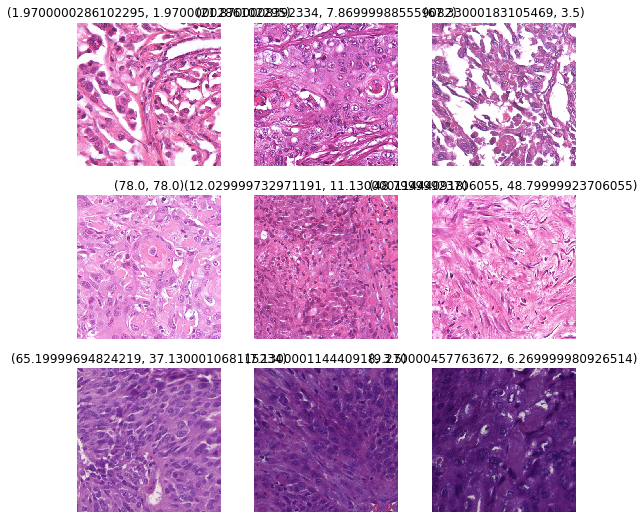

In [20]:
dls.show_batch()

# learner

## n

In [21]:
n=3

## create

In [22]:
arch = torchvision.models.resnet50

In [23]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}_regression')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/Deep_Learner/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [24]:
#learner.to_fp16()
print(learner.path)
learner.path.parent.mkdir(exist_ok=True)
learner.path.mkdir(exist_ok=True)

/home/Deep_Learner/private/datasets/urothel_ca/models/3-resnet50_regression


## name

In [25]:
epochs_frozen = 5
epochs_unfrozen = 10

In [26]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'3-resnet50'

## train

SuggestedLRs(valley=0.013182567432522774)

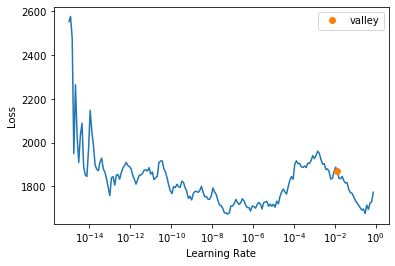

In [63]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

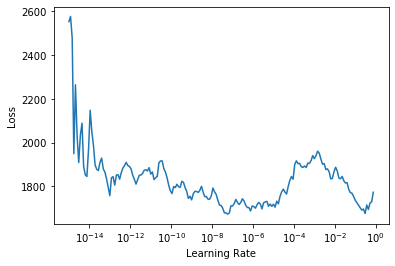

In [64]:
learner.recorder.plot_lr_find()

In [67]:
lr1 = 0.013182567432522774

In [68]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

epoch,train_loss,valid_loss,accuracy_multi,time


In [77]:
pd.read_csv(learner.path/log_head_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,754.931824,8.308810e+04,0.908985,6:42:26
1,1,538.500305,3.929061e+05,0.896247,8:05:31
2,2,410.115997,9.959066e+05,0.910439,8:40:43
3,3,353.809906,1.043100e+06,0.914664,9:43:54
4,4,348.166168,1.388828e+04,0.908612,9:03:09


In [27]:
nameHead = f'{nameBase}-head';nameHead

'3-resnet50-head'

In [ ]:
#learner.save(nameHead)
#learner.load(nameHead)

In [78]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

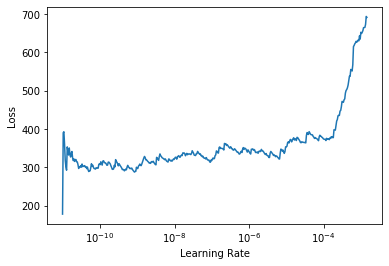

In [81]:
learner.recorder.plot_lr_find()

In [82]:
lr2 = 1e-10
lr3 = 1e-09
lr4 = 1e-08

In [83]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

epoch,train_loss,valid_loss,accuracy_multi,time
0,359.740082,27398.748047,0.906909,6:16:25
1,339.505280,677742.625000,0.913732,6:06:02


In [89]:
pd.read_csv(learner.path/log_complete_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,359.740082,2.739875e+04,0.906909,6:16:25
1,1,339.505280,6.777426e+05,0.913732,6:06:02
2,2,327.662231,2.523943e+06,0.913222,6:08:10
3,3,344.370148,1.441587e+06,0.905406,6:07:12
4,4,347.824768,3.051520e+04,0.907046,6:06:17
5,5,347.786133,2.267476e+06,0.912986,6:15:06
6,6,321.910675,3.824942e+06,0.911793,6:06:18
7,7,336.951385,6.961086e+05,0.915546,6:06:27
8,8,346.091522,2.164124e+06,0.910563,6:09:38
9,9,316.421448,7.549339e+05,0.912700,6:10:08


In [27]:
nameComplete = f'{nameBase}-complete'; nameComplete

'3-resnet50-complete'

In [28]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [29]:
from postprocessing.predictor import Predictor

## new predictions

In [57]:
predictor = Predictor(learner=learner, 
                      patient_manager=patient_manager, 
                      prediction_type=shared.enums.PredictionType.regression, 
                      classes=['Survival Time (months)','Recurrence Free Survival (months)'])

In [58]:
predictor.predict_on_tiles(tile_retrieval_type=shared.enums.TileRetrievalType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, 
                          batch_size=bs)

  0%|          | 0/40235 [00:00<?, ?it/s]

  0%|          | 1/40235 [00:01<18:57:32,  1.70s/it]

  0%|          | 2/40235 [00:02<14:38:46,  1.31s/it]

  0%|          | 3/40235 [00:02<11:47:39,  1.06s/it]

  0%|          | 4/40235 [00:02<9:32:50,  1.17it/s] 

  0%|          | 5/40235 [00:03<8:53:08,  1.26it/s]

  0%|          | 6/40235 [00:04<8:02:46,  1.39it/s]

  0%|          | 7/40235 [00:04<7:17:20,  1.53it/s]

  0%|          | 8/40235 [00:05<6:20:04,  1.76it/s]

  0%|          | 9/40235 [00:05<6:08:43,  1.82it/s]

  0%|          | 10/40235 [00:05<5:31:07,  2.02it/s]

  0%|          | 11/40235 [00:06<6:10:58,  1.81it/s]

  0%|          | 12/40235 [00:07<6:28:02,  1.73it/s]

  0%|          | 13/40235 [00:07<5:47:12,  1.93it/s]

  0%|          | 14/40235 [00:07<5:18:10,  2.11it/s]

  0%|          | 15/40235 [00:08<5:57:52,  1.87it/s]

  0%|          | 16/40235 [00:09<5:24:07,  2.07it/s]

  0%|          | 17/40235 [00:09<5:55:52,  1.88it/s]

  0%|          | 18/40235 [00:10<5:50:44,  1.91it/s]

  0%|          | 19/40235 [00:10<5:56:05,  1.88it/s]

  0%|          | 20/40235 [00:11<5:27:00,  2.05it/s]

  0%|          | 21/40235 [00:11<5:50:17,  1.91it/s]

  0%|          | 22/40235 [00:12<5:37:34,  1.99it/s]

  0%|          | 23/40235 [00:12<5:12:18,  2.15it/s]

  0%|          | 24/40235 [00:13<5:31:28,  2.02it/s]

  0%|          | 25/40235 [00:13<5:38:43,  1.98it/s]

  0%|          | 26/40235 [00:13<5:09:55,  2.16it/s]

  0%|          | 27/40235 [00:14<5:10:23,  2.16it/s]

  0%|          | 28/40235 [00:15<5:54:09,  1.89it/s]

  0%|          | 29/40235 [00:15<5:25:23,  2.06it/s]

  0%|          | 30/40235 [00:15<4:59:16,  2.24it/s]

  0%|          | 31/40235 [00:16<4:51:21,  2.30it/s]

  0%|          | 32/40235 [00:16<5:13:49,  2.14it/s]

  0%|          | 33/40235 [00:17<5:12:13,  2.15it/s]

  0%|          | 34/40235 [00:17<4:51:55,  2.30it/s]

  0%|          | 35/40235 [00:18<5:45:02,  1.94it/s]

  0%|          | 36/40235 [00:18<5:51:42,  1.90it/s]

  0%|          | 37/40235 [00:19<6:15:34,  1.78it/s]

  0%|          | 38/40235 [00:19<5:44:26,  1.95it/s]

  0%|          | 39/40235 [00:20<5:33:12,  2.01it/s]

  0%|          | 40/40235 [00:20<5:04:46,  2.20it/s]

  0%|          | 41/40235 [00:21<4:50:25,  2.31it/s]

KeyboardInterrupt: 

In [ ]:
predictor.predict_on_tiles(tile_retrieval_type=shared.enums.TileRetrievalType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.test,
                          tile_size=final_size, 
                          batch_size=bs)

## load patient manager with predictions from disc

In [30]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [31]:
pm_path_with_preds = Path(f'./patient_managers/00{n}/pm_with_preds_on_tiles.pickle')
pm_path_with_preds.parent.mkdir(exist_ok=True)

In [32]:
#save_as_pickle(patient_manager, pm_path_with_preds)
patient_manager = load_pickle(pm_path_with_preds)

In [35]:
predictor = Predictor(learner=learner, 
                      patient_manager=patient_manager, 
                      prediction_type=shared.enums.PredictionType.regression, 
                      classes=['Survival Time (months)','Recurrence Free Survival (months)'])

In [ ]:
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds = thresholds)

# evaluator

In [36]:
from postprocessing.evaluator import Evaluator

In [37]:
evaluator = Evaluator(predictor=predictor)

In [41]:
tiles_val = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)

In [42]:
tiles_test = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.test)

In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from wsi_processing_pipeline.shared import tile
import math

def get_ys_and_y_hats(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->List[List[float]]:
    """
    returns two 2-dimensional lists
    one containing the real labels and one the predictions
    """
    ys = []
    y_hats =[]
    for t in tiles:
        y = t.labels
        y_hat = [p.item() for p in t.predictions_raw.values()]   
        ys.append(y)
        y_hats.append(y_hat)
    return ys, y_hats
        

def mse(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    mean squared error
    needs tile.labels and tile.predictions_raw to be set
    """
    ys, y_hats = get_ys_and_y_hats(tiles)
    return mean_squared_error(y_true=ys, y_pred=y_hats)
    
def rmse(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    rooted mean squared error
    """
    return math.sqrt(mse(tiles))

def mae(tiles:List[wsi_processing_pipeline.shared.tile.Tile])->float:
    """
    mean absolute error
    """
    ys, y_hats = get_ys_and_y_hats(tiles)
    return mean_absolute_error(y_true=ys, y_pred=y_hats)

In [130]:
ts = tiles_val[:7000]

In [131]:
mse(ts)

121931.14754341228

In [132]:
rmse(ts)

349.1864080164236

In [134]:
mae(ts)

36.72660125008494